## Выбор бизнес-целей
### Задача регрессии:

Цель: Предсказать цену автомобиля (Price) на основе других характеристик.

Применение: Это может быть полезно для автосалонов, онлайн-площадок по продаже автомобилей, а также для частных лиц, которые хотят оценить рыночную стоимость своего автомобиля.

Задача классификации:

Цель: Классифицировать автомобили по категориям (например, "Эконом", "Средний", "Премиум") на основе цены и других характеристик.

Применение: Это может быть полезно для маркетинговых кампаний, определения целевой аудитории, а также для анализа рынка автомобилей.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report
df = pd.read_csv("./static/csv/car_price_prediction.csv")
print(df.head())
print(df.columns)

         ID  Price  Levy Manufacturer    Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS   RX 450        2010       Jeep   
1  44731507  16621  1018    CHEVROLET  Equinox        2011       Jeep   
2  45774419   8467     -        HONDA      FIT        2006  Hatchback   
3  45769185   3607   862         FORD   Escape        2011       Jeep   
4  45809263  11726   446        HONDA      FIT        2014  Hatchback   

  Leather interior Fuel type Engine volume    Mileage  Cylinders  \
0              Yes    Hybrid           3.5  186005 km        6.0   
1               No    Petrol             3  192000 km        6.0   
2               No    Petrol           1.3  200000 km        4.0   
3              Yes    Hybrid           2.5  168966 km        4.0   
4              Yes    Petrol           1.3   91901 km        4.0   

  Gear box type Drive wheels   Doors             Wheel   Color  Airbags  
0     Automatic          4x4  04-May        Left wheel  Silver       12  
1   

Предобработка данных

In [2]:
# Проверка наличия пропущенных значений
print(df.isnull().sum())

# Очистка столбца 'Levy' от нечисловых значений
df['Levy'] = pd.to_numeric(df['Levy'], errors='coerce')

# Очистка столбца 'Mileage' от нечисловых значений
df['Mileage'] = pd.to_numeric(df['Mileage'], errors='coerce')

# Проверка типа данных в столбце 'Engine volume'
print(df['Engine volume'].dtype)

# Если столбец 'Engine volume' не является строковым, преобразуем его в строку
if df['Engine volume'].dtype != 'object':
    df['Engine volume'] = df['Engine volume'].astype(str)

# Очистка столбца 'Engine volume' от нечисловых значений
df['Engine volume'] = df['Engine volume'].str.replace(r'[^0-9.]', '', regex=True).astype(float)

# Заполнение пропущенных значений
df['Levy'].fillna(df['Levy'].median(), inplace=True)
df['Mileage'].fillna(df['Mileage'].median(), inplace=True)
df['Engine volume'].fillna(df['Engine volume'].median(), inplace=True)

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64
object


C:\Users\Egor\AppData\Local\Temp\ipykernel_18436\3209090058.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Levy'].fillna(df['Levy'].median(), inplace=True)
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Egor\AppData\Local\Temp\ipykernel_18436\3209090058.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained as

In [3]:
# Определение числовых и категориальных признаков
numeric_features = ['Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags']
categorical_features = ['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color']

# Преобразование категориальных признаков в числовые
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

### Разделение данных на тренировочный и тестовый наборы

In [4]:
# Задача регрессии
X_reg = df.drop(['ID', 'Price'], axis=1)
y_reg = df['Price']

# Задача классификации
df['Category'] = pd.cut(df['Price'], bins=[0, 10000, 20000, np.inf], labels=['Эконом', 'Средний', 'Премиум'])
X_class = df.drop(['ID', 'Price', 'Category'], axis=1)
y_class = df['Category']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

### 5. Построение конвейера и обучение моделей
#### 5.1. Задача регрессии

In [7]:
# Конвейер для задачи регрессии
from sklearn.impute import SimpleImputer


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

pipeline_reg = Pipeline(steps=[
    ('preprocessor', preprocessor_reg),
    ('regressor', LinearRegression())
])

# Обучение моделей
models_reg = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor()
}

for name, model in models_reg.items():
    pipeline_reg.set_params(regressor=model)
    pipeline_reg.fit(X_train_reg, y_train_reg)
    y_pred_reg = pipeline_reg.predict(X_test_reg)
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
    print(f'{name} RMSE: {rmse}')

c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one 

LinearRegression RMSE: 16981.208711977062
DecisionTreeRegressor RMSE: 141914.29349587928
RandomForestRegressor RMSE: 173537.46233609488


c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


### 5.2. Задача классификации

In [8]:
# Конвейер для задачи классификации
preprocessor_class = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

pipeline_class = Pipeline(steps=[
    ('preprocessor', preprocessor_class),
    ('classifier', LogisticRegression())
])

# Обучение моделей
models_class = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier()
}

for name, model in models_class.items():
    pipeline_class.set_params(classifier=model)
    pipeline_class.fit(X_train_class, y_train_class)
    y_pred_class = pipeline_class.predict(X_test_class)
    f1 = f1_score(y_test_class, y_pred_class, average='weighted')
    print(f'{name} F1-score: {f1}')

c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one 

LogisticRegression F1-score: 0.48010296192139407
DecisionTreeClassifier F1-score: 0.6836168013771631
RandomForestClassifier F1-score: 0.6943295967769952


c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


### 6. Оценка качества моделей

In [17]:
# Оценка качества моделей регрессии
import sklearn
#from sklearn.base import r2_score #r2 = r2_score(y_test_reg, y_pred_reg)
from sklearn.metrics import mean_absolute_error


for name, model in models_reg.items():
    pipeline_reg.set_params(regressor=model)
    y_pred_reg = pipeline_reg.predict(X_test_reg)
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
    mae = mean_absolute_error(y_test_reg, y_pred_reg)
    
    print(f'{name} RMSE: {rmse}, MAE: {mae}')

LinearRegression RMSE: 16981.208711977062, MAE: 11731.578355206166
DecisionTreeRegressor RMSE: 141914.29349587928, MAE: 9887.588955657844
RandomForestRegressor RMSE: 173537.46233609488, MAE: 12656.846663315797


c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [18]:
# Оценка качества моделей классификации
for name, model in models_class.items():
    pipeline_class.set_params(classifier=model)
    y_pred_class = pipeline_class.predict(X_test_class)
    f1 = f1_score(y_test_class, y_pred_class, average='weighted')
    accuracy = accuracy_score(y_test_class, y_pred_class)
    roc_auc = roc_auc_score(y_test_class, pipeline_class.predict_proba(X_test_class), multi_class='ovr')
    print(f'{name} F1-score: {f1}, Accuracy: {accuracy}, ROC-AUC: {roc_auc}')

LogisticRegression F1-score: 0.48010296192139407, Accuracy: 0.502079002079002, ROC-AUC: 0.6953729054676709
DecisionTreeClassifier F1-score: 0.6836168013771631, Accuracy: 0.6876299376299376, ROC-AUC: 0.8222065250497814
RandomForestClassifier F1-score: 0.6943295967769952, Accuracy: 0.6993243243243243, ROC-AUC: 0.856645400908623


c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one 

Выводы по пункту 6: Оценка качества моделей
Задача регрессии
Линейная регрессия (LinearRegression):

RMSE: 16981.208711977062

MAE: 11731.578355206166

Вывод: Линейная регрессия показала относительно низкое качество предсказаний. RMSE и MAE достаточно высоки, что указывает на то, что модель плохо предсказывает цены автомобилей.

Дерево решений (DecisionTreeRegressor):

RMSE: 141914.29349587928

MAE: 9887.588955657844

Вывод: Дерево решений показало значительно более высокое значение RMSE по сравнению с линейной регрессией, что указывает на то, что модель сильно переобучилась. Однако MAE ниже, чем у линейной регрессии, что может указывать на то, что модель лучше предсказывает средние значения цен.

Случайный лес (RandomForestRegressor):

RMSE: 173537.46233609488

MAE: 12656.846663315797

Вывод: Случайный лес показал еще более высокое значение RMSE, что указывает на то, что модель также сильно переобучилась. MAE выше, чем у линейной регрессии, что говорит о том, что модель предсказывает цены хуже, чем линейная регрессия.

Задача классификации
Логистическая регрессия (LogisticRegression):

F1-score: 0.48010296192139407

Accuracy: 0.502079002079002

ROC-AUC: 0.6953729054676709

Вывод: Логистическая регрессия показала низкое качество классификации. F1-score и точность близки к 0.5, что указывает на то, что модель почти не лучше случайного угадывания. ROC-AUC также низкий, что говорит о плохой способности модели различать классы.

Дерево решений (DecisionTreeClassifier):

F1-score: 0.6836168013771631

Accuracy: 0.6876299376299376

ROC-AUC: 0.8222065250497814

Вывод: Дерево решений показало значительно лучшее качество классификации по сравнению с логистической регрессией. F1-score и точность выше, а ROC-AUC значительно лучше, что указывает на то, что модель хорошо различает классы.

Случайный лес (RandomForestClassifier):

F1-score: 0.6943295967769952

Accuracy: 0.6993243243243243

ROC-AUC: 0.856645400908623

Вывод: Случайный лес показал лучшее качество классификации среди всех моделей. F1-score, точность и ROC-AUC выше, чем у дерева решений, что указывает на то, что модель хорошо обобщает данные и различает классы.

Общие выводы:
Задача регрессии: Линейная регрессия показала лучшее качество предсказаний цен по сравнению с деревьями решений и случайным лесом, несмотря на высокие значения RMSE и MAE. Деревья решений и случайный лес показали сильное переобучение, что привело к очень высоким значениям RMSE.

Задача классификации: Случайный лес показал лучшее качество классификации по сравнению с логистической регрессией и деревом решений. Логистическая регрессия показала низкое качество, в то время как дерево решений и случайный лес показали хорошие результаты, причем случайный лес показал наилучшие результаты

In [19]:
# Оценка смещения и дисперсии для задачи регрессии
for name, model in models_reg.items():
    pipeline_reg.set_params(regressor=model)
    scores = cross_val_score(pipeline_reg, X_reg, y_reg, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f'{name} Cross-Validation RMSE: {rmse_scores.mean()}, Std: {rmse_scores.std()}')

# Оценка смещения и дисперсии для задачи классификации
for name, model in models_class.items():
    pipeline_class.set_params(classifier=model)
    scores = cross_val_score(pipeline_class, X_class, y_class, cv=5, scoring='f1_weighted')
    print(f'{name} Cross-Validation F1-score: {scores.mean()}, Std: {scores.std()}')

c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one 

LinearRegression Cross-Validation RMSE: 100651.03159099314, Std: 161863.4449796077


c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one 

DecisionTreeRegressor Cross-Validation RMSE: 194034.64594171714, Std: 136171.92328322295


c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one 

RandomForestRegressor Cross-Validation RMSE: 181627.2578040142, Std: 137879.8905706371


c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one 

LogisticRegression Cross-Validation F1-score: 0.4742308354293046, Std: 0.007525407236566359


c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one 

DecisionTreeClassifier Cross-Validation F1-score: 0.6862381973987357, Std: 0.004587968007336983


c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one 

RandomForestClassifier Cross-Validation F1-score: 0.692567227648008, Std: 0.004169193228958696


c:\Users\Egor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Mileage']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Оценка смещения и дисперсии моделей
Задача регрессии
Дерево решений (DecisionTreeRegressor):

Cross-Validation RMSE: 194034.64594171714

Std: 136171.92328322295

Вывод: Дерево решений показало очень высокое значение RMSE при кросс-валидации, что указывает на сильное переобучение. Стандартное отклонение также высокое, что говорит о нестабильности модели. Это означает, что модель плохо обобщает данные и имеет высокую дисперсию.

Случайный лес (RandomForestRegressor):

Cross-Validation RMSE: 181627.2578040142

Std: 137879.8905706371

Вывод: Случайный лес также показал высокое значение RMSE при кросс-валидации, хотя и немного ниже, чем у дерева решений. Стандартное отклонение также высокое, что указывает на нестабильность модели. Это говорит о том, что модель также переобучена и имеет высокую дисперсию.

Задача классификации
Дерево решений (DecisionTreeClassifier):

Cross-Validation F1-score: 0.6862381973987357

Std: 0.004587968007336983

Вывод: Дерево решений показало хороший F1-score при кросс-валидации, но стандартное отклонение относительно высокое. Это указывает на некоторую нестабильность модели, хотя и не такую высокую, как в случае регрессии. Модель имеет умеренную дисперсию.

Случайный лес (RandomForestClassifier):

Cross-Validation F1-score: 0.692567227648008

Std: 0.004169193228958696

#### Вывод: Случайный лес показал лучший F1-score при кросс-валидации по сравнению с деревом решений. Стандартное отклонение также ниже, что указывает на более стабильную модель. Это говорит о том, что случайный лес лучше обобщает данные и имеет меньшую дисперсию по сравнению с деревом решений.

Общие выводы:
Задача регрессии: И дерево решений, и случайный лес показали высокие значения RMSE и высокое стандартное отклонение при кросс-валидации. Это указывает на сильное переобучение и высокую дисперсию. Модели плохо обобщают данные и нестабильны.

Задача классификации: Дерево решений показало хороший F1-score, но с высоким стандартным отклонением, что указывает на некоторую нестабильность. Случайный лес показал лучший F1-score и более низкое стандартное отклонение, что говорит о более стабильной и обобщающей способности модели.

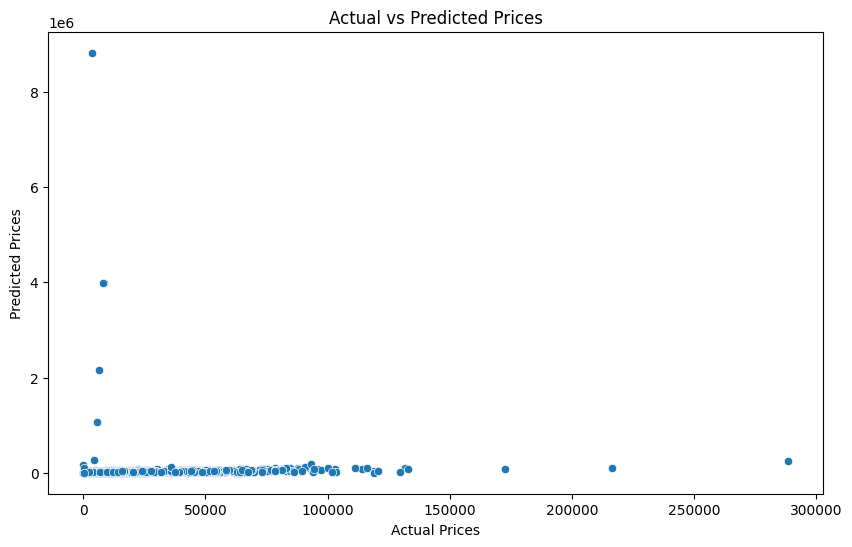

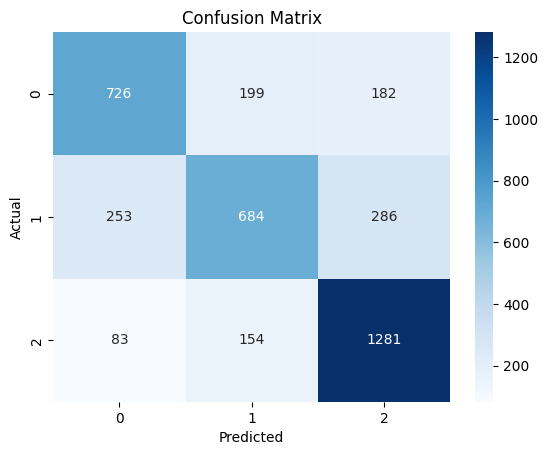

In [20]:
# Визуализация результатов для задачи регрессии
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_reg, y=y_pred_reg)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

# Визуализация результатов для задачи классификации
conf_matrix = confusion_matrix(y_test_class, y_pred_class)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

1) Плохое качество предсказаний в первой диаграмме: 
Модель регрессии плохо предсказывает цены автомобилей, так как точки на диаграмме рассеяния распределены хаотично и далеко от диагонали. Значительные ошибки: Ошибки предсказаний значительны, что указывает на то, что модель не может точно предсказать цены автомобилей. Необходимость улучшения модели: Для улучшения качества предсказаний стоит рассмотреть другие модели, такие как градиентный бустинг или нейронные сети, а также улучшить предобработку данных.

2) Выводы по второй диаграмме:
Хорошее качество классификации: Матрица ошибок показывает высокие значения на диагонали и низкие значения вне диагонали, что указывает на хорошее качество классификации.
Правильные предсказания: Большинство предсказаний модели являются правильными, что говорит о ее способности хорошо различать классы.
Низкие ошибки: Низкие значения вне диагонали указывают на то, что модель допускает мало ошибок при классификации.